In [1]:
import torch.nn as nn
import sys
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# For drive
path = "/content/drive/My Drive/project/"

sys.path.append(path + "URP")
sys.path.append(path + "URP/learning")
sys.path.append(path + "URP/data")
sys.path.append(path + "URP/models")
sys.path.append(path + "URP/forgetting")

In [ ]:
# For PC
path = ".."
sys.path.append(path)
sys.path.append(path + "/learning")
sys.path.append(path + "/data")
sys.path.append(path + "/models")
sys.path.append(path + "/forgetting")

In [10]:
from data_utils import *#show_random, AddNoise, remove_random, remove_class, combine_datasets
from data import get_dataset, dummy_clusters, dummy_half_doughnuts
from models_utils import *
import models
from learn import *
from forget import *
from utils import set_seed

In [5]:
set_seed()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

SEED SET TO:  13


device(type='cuda', index=0)

##Models and Datasets

In [6]:
cifar10_train, cifar10_val, cifar10_test = get_dataset("cifar10", batch_size=32, cuda=0,
                  train_size=10000, val_size=2000, test_size=1000,
                  test_batch_size=32)
print('-'*20)

cnn = {"filters_percentage": 1, "n_channels":3,"num_classes": 50, "dropout": True, "batch_norm": True}
cnn_model = get_model("cnn", **cnn)
print(cnn_model.__class__.__name__)
print('-'*20)

checkpoint = torch.load(f"/content/drive/My Drive/project/URP/checkpoints/{cnn_model.__class__.__name__}_{70}.pth.tar")
cnn_model.load_state_dict(checkpoint['model'])
_ = test(model=cnn_model, loss='ce', lossfn=None, optimizer='adam', device=device, dataset='cifar', test_loader=cifar10_test, at_epoch=None)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /root/data/cifar-10-python.tar.gz to /root/data
Dataset sizes: 	 train: 10000 	 val: 2000 	 test: 1000
Batch size: 	 32
--------------------
CNN
--------------------
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.9684426188468933
Error:  0.125
FINISHED TESTING


In [ ]:
mnist_train, mnist_val, mnist_test = get_dataset("mnist", batch_size=32, cuda=0,
                  train_size=10000, val_size=2000, test_size=1000,
                  test_batch_size=32)
print('-'*20)

dnn = {"input_size": 1024, "hidden_size":64, "num_classes":10,"num_layer": 10, "activation": nn.ReLU()}
dnn_model = get_model("mlp", **dnn)
print(dnn_model.__class__.__name__)
print('-'*20)

checkpoint = torch.load(f"/content/drive/My Drive/project/URP/checkpoints/{dnn_model.__class__.__name__}_{50}.pth.tar")
dnn_model.load_state_dict(checkpoint['model'])
_ = test(model=dnn_model, loss='ce', lossfn=None, optimizer='sgd', device=device, dataset='mnist', test_loader=mnist_test, at_epoch=None)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /root/data/MNIST/raw/train-images-idx3-ubyte.gz to /root/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /root/data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /root/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /root/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/data/MNIST/raw

Dataset sizes: 	 train: 10000 	 val: 2000 	 test: 1000
Batch size: 	 32
--------------------
MLP
--------------------


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Optimizer: 	  sgd

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.027804553508758545
Error:  0.0
FINISHED TESTING


In [ ]:
cifar100_train, cifar100_val, cifar100_test = get_dataset("cifar100", batch_size=32, cuda=0,
                  train_size=20000, val_size=2000, test_size=1000,
                  test_batch_size=10)
print('-'*20)

resnet18 = {"filters_percentage": 0.4, "n_channels":3,"num_classes": 100, "block": ResBlock, "num_blocks": [2,2,2,2]}
resnet18_model = get_model("resnet18", **resnet18)
print(resnet18_model.__class__.__name__)
print('-'*20)

checkpoint = torch.load(f"/content/drive/My Drive/project/URP/checkpoints/{resnet18_model.__class__.__name__}_{200}.pth.tar")
resnet18_model.load_state_dict(checkpoint['model'])
_ = test(model=resnet18_model, loss='ce', lossfn=None, optimizer='sgd', device=device, dataset='cifar', test_loader=cifar100_test, at_epoch=None)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting /root/data/cifar-100-python.tar.gz to /root/data
Dataset sizes: 	 train: 20000 	 val: 2000 	 test: 1000
Batch size: 	 32
--------------------
ResNet18
--------------------
Optimizer: 	  sgd

Loss function:
CrossEntropyLoss()
TESTING
Loss:  3.240086078643799
Error:  0.5
FINISHED TESTING


## My methods

In [ ]:
forget, retain = remove_class(cifar10_test, [0])
noise = AddNoise(mean=0, std=0.1)
noisy_forget = noise.encode_data(forget)
noisy_retain = noise.encode_data(retain)
#show_random(noisy_retain, 3)
#concat = combine_datasets(noisy_forget, noisy_retain)
concat = combine_datasets(noisy_forget, retain)
# It is not working well when you shuffle dataset!

Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  1.0722668170928955
Error:  0.2222222089767456
FINISHED TESTING
--------------------
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
[Logging in CNN_training]
[0] train metrics:{"loss": 1.71198570728302, "error": 0.75}
[0] test metrics:{"loss": 3.8479394912719727, "error": 0.8888888880610466}
Epoch number: 0 
Epoch Time: 0.8 sec
[1] train metrics:{"loss": 1.1694140434265137, "error": 0.5}
[1] test metrics:{"loss": 1.3794323205947876, "error": 0.4444444179534912}
Epoch number: 1 
Epoch Time: 0.8 sec
[2] train metrics:{"loss": 0.45161551237106323, "error": 0.0}
[2] test metrics:{"loss": 0.7571812868118286, "error": 0.3333333134651184}
Epoch number: 2 
Epoch Time: 0.79 sec
[3] train metrics:{"loss": 0.40395432710647583, "error": 0.125}
[3] test metrics:{"loss": 1.1275794506072998, "error": 0.5555555522441864}
Epoch number: 3 
Epoch Time: 0.8 sec
[4] train metrics:{"loss": 0.3729504942893982, "error": 0.125}
[4] test

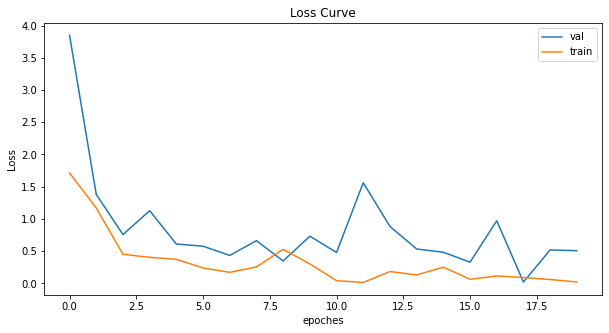

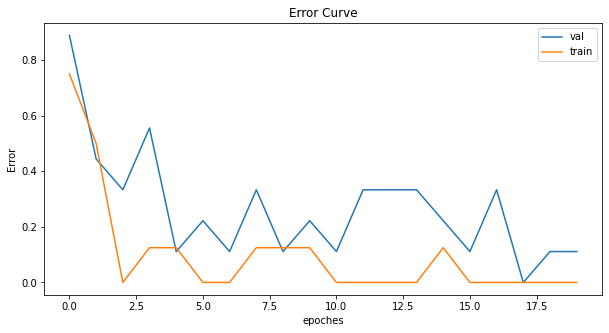

Forget time is: 16.321418285369873
--------------------
ON RETAINED DATASET
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
[20] test metrics:{"loss": 0.5073521733283997, "error": 0.1111111044883728}
FINISHED TESTING
--------------------
ON FORGOT DATASET
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
[20] test metrics:{"loss": 2.5046474933624268, "error": 0.9354838728904724}
FINISHED TESTING


In [ ]:
checkpoint = torch.load(f"/content/drive/My Drive/project/URP/checkpoints/{cnn_model.__class__.__name__}_{70}.pth.tar")
cnn_model.load_state_dict(checkpoint['model'])
_ = test(model=cnn_model, loss='ce', lossfn=None, optimizer='adam', device=device, dataset=retain, test_loader=retain, at_epoch=None)
print('-'*20)
_ = fine_tune(cnn_model, loss='ce', optimizer='adam', epochs=20, device=device, dataset='cifar', lossfn=None, train_loader=concat, val_loader=retain,
    scheduler=None, weight_decay=0, lr=0.01, momentum=0, name='fine_tune')
print('-'*20)
print('ON RETAINED DATASET')
_ = test(model=cnn_model, loss='ce', lossfn=None, optimizer='adam', device=device, dataset='cifar', test_loader=retain, at_epoch=20)
print('-'*20)
print('ON FORGOT DATASET')
_ = test(model=cnn_model, loss='ce', lossfn=None, optimizer='adam', device=device, dataset='cifar', test_loader=forget, at_epoch=20)

In [ ]:
forget, retain = remove_class(mnist_test, [0])
noise = AddNoise(mean=0, std=0.9)
noisy_forget = noise.encode_data(forget)
noisy_retain = noise.encode_data(retain)
#show_random(noisy_retain, 3)
concat = combine_datasets(noisy_forget, retain, shuffle=True)

Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.04301946982741356
Error:  0.0
FINISHED TESTING
--------------------
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
[Logging in MLP_training]
[0] train metrics:{"loss": 0.7254893779754639, "error": 0.25}
[0] test metrics:{"loss": 0.2980663478374481, "error": 0.09999996423721313}
Epoch number: 0 
Epoch Time: 0.2 sec
[1] train metrics:{"loss": 1.5119752883911133, "error": 0.125}
[1] test metrics:{"loss": 0.6266961693763733, "error": 0.16666662693023682}
Epoch number: 1 
Epoch Time: 0.19 sec
[2] train metrics:{"loss": 0.24308790266513824, "error": 0.0}
[2] test metrics:{"loss": 0.1772562563419342, "error": 0.0}
Epoch number: 2 
Epoch Time: 0.19 sec
[3] train metrics:{"loss": 0.4124963581562042, "error": 0.25}
[3] test metrics:{"loss": 0.19499439001083374, "error": 0.03333330154418945}
Epoch number: 3 
Epoch Time: 0.21 sec
[4] train metrics:{"loss": 0.5598993897438049, "error": 0.125}
[4] test metrics:{"loss": 0.4

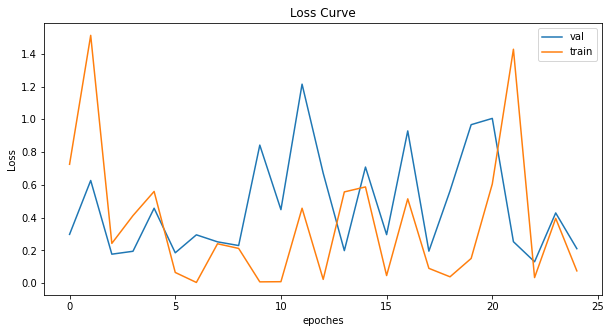

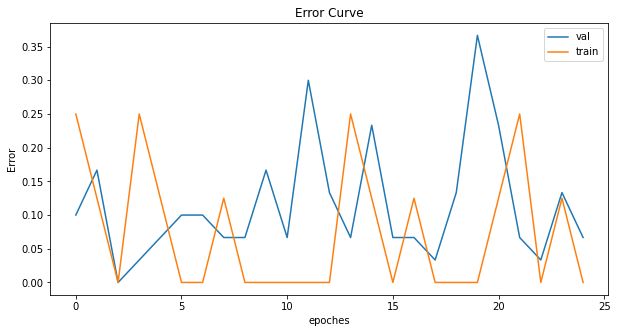

Forget time is: 5.295017957687378
--------------------
ON RETAINED DATASET
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
[25] test metrics:{"loss": 0.21085397899150848, "error": 0.0666666030883789}
FINISHED TESTING
--------------------
ON FORGOT DATASET
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
[25] test metrics:{"loss": 4.333977222442627, "error": 0.699999988079071}
FINISHED TESTING


In [ ]:
checkpoint = torch.load(f"/content/drive/My Drive/project/URP/checkpoints/{dnn_model.__class__.__name__}_{50}.pth.tar")
dnn_model.load_state_dict(checkpoint['model'])
_ = test(model=dnn_model, loss='ce', lossfn=None, optimizer='adam', device=device, dataset=retain, test_loader=retain, at_epoch=None)
print('-'*20)
_ = fine_tune(dnn_model, loss='ce', optimizer='adam', epochs=25, device=device, dataset='cifar', lossfn=None, train_loader=concat, val_loader=retain,
    scheduler=None, weight_decay=0, lr=0.01, momentum=0, name='fine_tune')
print('-'*20)
print('ON RETAINED DATASET')
_ = test(model=dnn_model, loss='ce', lossfn=None, optimizer='adam', device=device, dataset='cifar', test_loader=retain, at_epoch=25)
print('-'*20)
print('ON FORGOT DATASET')
_ = test(model=dnn_model, loss='ce', lossfn=None, optimizer='adam', device=device, dataset='cifar', test_loader=forget, at_epoch=25)

In [ ]:
forget, retain = remove_class(cifar100_test, [0])
noise = AddNoise(mean=0, std=0.4)
noisy_forget = noise.encode_data(forget)
noisy_retain = noise.encode_data(retain)
#show_random(noisy_retain, 3)
concat = combine_datasets(noisy_forget, retain)

Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  3.59869122505188
Error:  0.5555555522441864
FINISHED TESTING
--------------------
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
[Logging in ResNet18_training]
[0] train metrics:{"loss": 5.069759368896484, "error": 0.8999999985098839}
[0] test metrics:{"loss": 4.215310573577881, "error": 0.8888888880610466}
Epoch number: 0 
Epoch Time: 2.36 sec
[1] train metrics:{"loss": 4.421563148498535, "error": 0.7999999970197678}
[1] test metrics:{"loss": 3.8995771408081055, "error": 0.6666666567325592}
Epoch number: 1 
Epoch Time: 2.34 sec
[2] train metrics:{"loss": 3.3640828132629395, "error": 0.8999999985098839}
[2] test metrics:{"loss": 3.9476563930511475, "error": 0.7777777761220932}
Epoch number: 2 
Epoch Time: 2.35 sec
[3] train metrics:{"loss": 2.710216760635376, "error": 0.699999988079071}
[3] test metrics:{"loss": 2.7752249240875244, "error": 0.7777777761220932}
Epoch number: 3 
Epoch Time: 2.34 sec
[4] train met

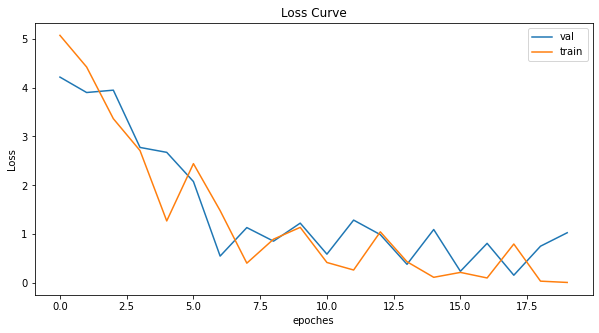

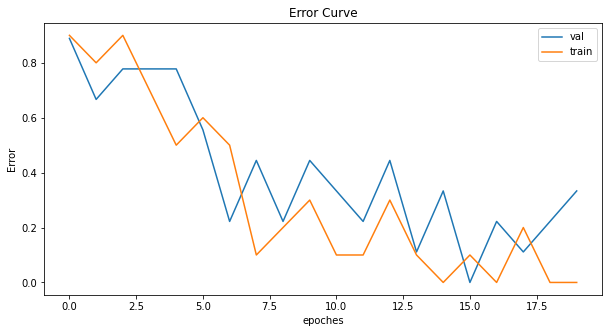

Forget time is: 47.62594532966614
--------------------
ON RETAINED DATASET
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
[20] test metrics:{"loss": 1.0291393995285034, "error": 0.3333333134651184}
FINISHED TESTING
--------------------
ON FORGOT DATASET
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
[20] test metrics:{"loss": 6.020230770111084, "error": 1.0}
FINISHED TESTING


In [ ]:
checkpoint = torch.load(f"/content/drive/My Drive/project/URP/checkpoints/{resnet18_model.__class__.__name__}_{200}.pth.tar")
resnet18_model.load_state_dict(checkpoint['model'])
_ = test(model=resnet18_model, loss='ce', lossfn=None, optimizer='adam', device=device, dataset=retain, test_loader=retain, at_epoch=None)
print('-'*20)
_ = fine_tune(resnet18_model, loss='ce', optimizer='adam', epochs=20, device=device, dataset='cifar', lossfn=None, train_loader=concat, val_loader=retain,
    scheduler=None, weight_decay=0, lr=0.001, momentum=0, name='fine_tune')
print('-'*20)
print('ON RETAINED DATASET')
_ = test(model=resnet18_model, loss='ce', lossfn=None, optimizer='adam', device=device, dataset='cifar', test_loader=retain, at_epoch=20)
print('-'*20)
print('ON FORGOT DATASET')
_ = test(model=resnet18_model, loss='ce', lossfn=None, optimizer='adam', device=device, dataset='cifar', test_loader=forget, at_epoch=20)

Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.9684426188468933
Error:  0.125
FINISHED TESTING
FORGETTING IMPLEMENTATION
--------------------
INITIAL Df PERFOMANCE
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.717379629611969
Error:  0.19354844093322754
FINISHED TESTING
--------------------
INITIAL Dr PERFOMANCE
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  1.0722668170928955
Error:  0.2222222089767456
FINISHED TESTING
--------------------
FORGETTING PROCESS
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
[Logging in CNN_training]
[0] train metrics:{"loss": 0.06146679446101189, "error": 0.0}
[0] test metrics:{"loss": 3.0746920108795166, "error": 0.9032258093357086}
Epoch number: 0 
Epoch Time: 6.44 sec
[1] train metrics:{"loss": 0.013911325484514236, "error": 0.0}
[1] test metrics:{"loss": 4.02851676940918, "error": 0.9677419364452362}
Epoch number: 1 
Epoch Time: 6.44 sec
[2] train metrics:{"loss": 0.0748763

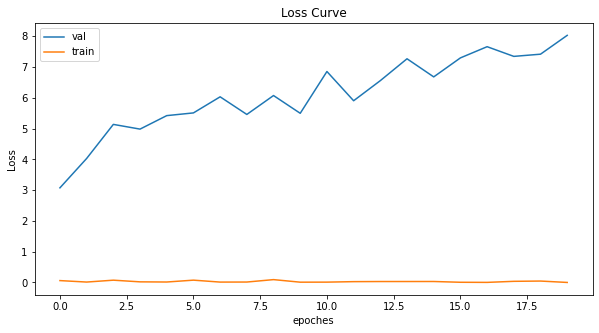

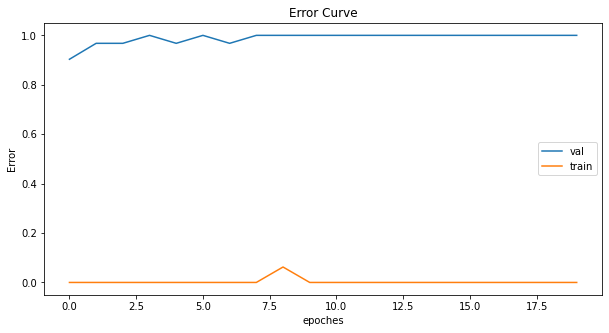

Forget time is: 129.17894554138184
--------------------
FINAL Df PERFOMANCE
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  8.028120040893555
Error:  1.0
FINISHED TESTING
--------------------
FINAL Dr PERFOMANCE
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  1.2261978387832642
Error:  0.3333333134651184
FINISHED TESTING


In [ ]:
checkpoint = torch.load(f"/content/drive/My Drive/project/URP/checkpoints/{cnn_model.__class__.__name__}_{70}.pth.tar")
cnn_model.load_state_dict(checkpoint['model'])
_ = test(model=cnn_model, loss='ce', lossfn=None, optimizer='adam', device=device, dataset='cifar', test_loader=cifar10_test, at_epoch=None)
print('FORGETTING IMPLEMENTATION')
# All in one function
FD(class_id=0, mean=0, std=0.1, model=cnn_model, loss='ce', optimizer='adam', epochs=20, device=device, dataset='cifar', lossfn=None, train_loader=cifar10_train, val_loader=cifar10_test,
    scheduler=None, weight_decay=0.0, lr=0.001, momentum=0., name="FD")

Optimizer: 	  sgd

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.027804553508758545
Error:  0.0
FINISHED TESTING
FORGETTING IMPLEMENTATION
--------------------
INITIAL Df PERFOMANCE
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.04038366675376892
Error:  0.0
FINISHED TESTING
--------------------
INITIAL Dr PERFOMANCE
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.04301946982741356
Error:  0.0
FINISHED TESTING
--------------------
FORGETTING PROCESS
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
[Logging in MLP_training]
[0] train metrics:{"loss": 0.17073367536067963, "error": 0.0625}
[0] test metrics:{"loss": 2.6123318672180176, "error": 1.0}
Epoch number: 0 
Epoch Time: 1.37 sec
[1] train metrics:{"loss": 0.10263083130121231, "error": 0.0625}
[1] test metrics:{"loss": 2.461833953857422, "error": 1.0}
Epoch number: 1 
Epoch Time: 1.36 sec
[2] train metrics:{"loss": 0.026493346318602562, "error": 0.0}
[2] test metrics:{"loss": 

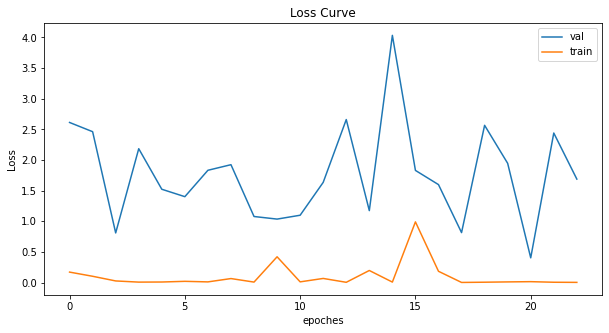

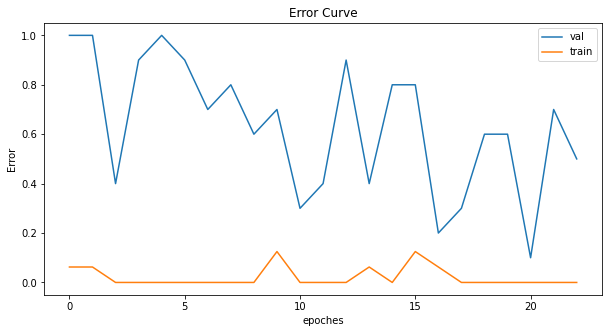

Forget time is: 31.789156913757324
--------------------
FINAL Df PERFOMANCE
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  1.6882312297821045
Error:  0.5
FINISHED TESTING
--------------------
FINAL Dr PERFOMANCE
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.30188611149787903
Error:  0.0666666030883789
FINISHED TESTING


In [ ]:
checkpoint = torch.load(f"/content/drive/My Drive/project/URP/checkpoints/{dnn_model.__class__.__name__}_{50}.pth.tar")
dnn_model.load_state_dict(checkpoint['model'])
_ = test(model=dnn_model, loss='ce', lossfn=None, optimizer='sgd', device=device, dataset='mnist', test_loader=mnist_test, at_epoch=None)
print('FORGETTING IMPLEMENTATION')
# All in one function
FD(class_id=0, mean=0, std=1.0, model=dnn_model, loss='ce', optimizer='adam', epochs=30, device=device, dataset='mnist', lossfn=None, train_loader=mnist_train, val_loader=mnist_test,
    scheduler=None, weight_decay=0.0, lr=0.002, momentum=0., name="FD")

In [ ]:
!ls checkpoints
from google.colab import files
files.download('./checkpoints/ResNet18_20.pth.tar')

CNN_10.pth.tar	CNN_5.pth.tar  MLP_16.pth.tar  MLP_25.pth.tar
CNN_20.pth.tar	CNN_8.pth.tar  MLP_20.pth.tar  ResNet18_20.pth.tar


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!ls checkpoints
files.download('./checkpoints/CNN_20.pth.tar')

CNN_10.pth.tar	CNN_5.pth.tar  ResNet18_20.pth.tar
CNN_20.pth.tar	CNN_8.pth.tar


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!ls checkpoints
files.download('./checkpoints/MLP_23.pth.tar')

CNN_10.pth.tar	CNN_8.pth.tar	MLP_18.pth.tar	MLP_23.pth.tar
CNN_20.pth.tar	MLP_15.pth.tar	MLP_19.pth.tar	MLP_25.pth.tar
CNN_5.pth.tar	MLP_16.pth.tar	MLP_20.pth.tar	ResNet18_20.pth.tar


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  tensor(0)


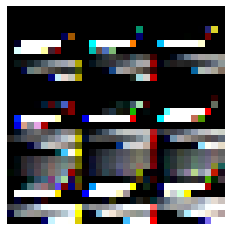

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1
3
Label:  tensor(0)


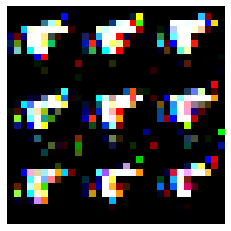

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  tensor(0)


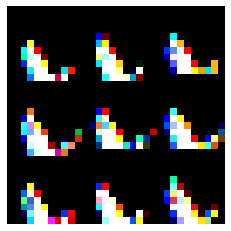

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  tensor(0)


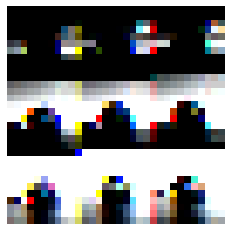

In [16]:
def get_random_img(ds):
  n_batch = len(ds)
  rand_batch = int(np.random.random() * n_batch)
  #imgs, labs = ds[rand_batch]
  for i, (s_imgs, s_labs) in enumerate(ds):
    if i < rand_batch:
      continue
    imgs, labs = s_imgs, s_labs 
    break
  n_imgs = len(imgs)
  rand_idx = int(np.random.random() * n_imgs)
  img = imgs[rand_idx]
  lab = labs[rand_idx]
  return img, lab

def get_random(ds, num):
  imgs = []
  labs = []
  for i in range(num):
    img, lab = get_random_img(ds)
    imgs.append(img)
    labs.append(lab)
  dataset = ForgetDataset(imgs, labs)
  dataloader = DataLoader(dataset, ds.batch_size)
  return dataloader
  # finish here!


img, lab = get_random_img(cifar10_test)
img = img.view(32, 32, -1)
print("Label: ", lab)
plt.axis('off')
plt.imshow(img)
plt.show()

ds = get_random(cifar10_test, 3)
print(len(ds))
for imgs, labs in ds:
  print(len(imgs))
  for img in imgs:
    img = img.view(32, 32, -1)
    print("Label: ", lab)
    plt.axis('off')
    plt.imshow(img)
    plt.show()


In [34]:
def predict(model, img):
  img.unsqueeze_(0)
  return torch.argmax(model(img))

img, lab = get_random_img(cifar10_test)
print(lab)
img1 = img.cuda()
#img.unsqueeze_(0)

predict(cnn_model, img1)

tensor(8)


tensor(8, device='cuda:0')

In [35]:
noise = AddNoise(mean=0, std=0.9)
noisy_img = noise.encodes(img)
print(noisy_img.shape)
img1 = noisy_img.cuda()
print(lab)
predict(cnn_model, img1)


torch.Size([3, 32, 32])
tensor(8)


tensor(2, device='cuda:0')

##Classical methods

In [ ]:
forget, retain = remove_class(cifar10_test, [0])

In [ ]:
neg_gradient(dnn_model, loss='ce', optimizer='adam', epochs=20, device=device, dataset="mnist", lossfn=None, train_loader=forget, val_loader=retain,
    scheduler=None, weight_decay=0.0, lr=0.01, momentum=0)

Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
[Logging in MLP_training]
[0] train metrics:{"loss": 0.0, "error": 0.0}
[0] test metrics:{"loss": 123.75914764404297, "error": 0.9285714253783226}
Epoch number: 0 :
 Epoch Time: 0.91 sec
[1] train metrics:{"loss": 0.0, "error": 0.0}
[1] test metrics:{"loss": 123.75914764404297, "error": 0.9285714253783226}
Epoch number: 1 :
 Epoch Time: 0.85 sec
[2] train metrics:{"loss": 0.0, "error": 0.0}
[2] test metrics:{"loss": 123.75914764404297, "error": 0.9285714253783226}
Epoch number: 2 :
 Epoch Time: 0.82 sec
[3] train metrics:{"loss": 0.0, "error": 0.0}
[3] test metrics:{"loss": 123.75914764404297, "error": 0.9285714253783226}
Epoch number: 3 :
 Epoch Time: 0.88 sec
[4] train metrics:{"loss": 0.0, "error": 0.0}
[4] test metrics:{"loss": 123.75914764404297, "error": 0.9285714253783226}
Epoch number: 4 :
 Epoch Time: 0.83 sec
[5] train metrics:{"loss": 0.0, "error": 0.0}
[5] test metrics:{"loss": 123.75914764404297, "error": 0.928571425378

In [ ]:
test(model=dnn_model, loss='ce', lossfn=None, optimizer='adam', device=device, dataset='mnist', test_loader=retain, at_epoch=20, name="neg_gradient")

Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
[20] test metrics:{"loss": 123.75914764404297, "error": 0.9285714253783226}
FINISHED TESTING


MLP(
  (activation): ReLU()
  (layers): Sequential(
    (0): Layer(in_features=1024, out_features=32, bias=True, beta=0.31622776601683794)
    (1): ReLU()
    (2): Layer(in_features=32, out_features=32, bias=True, beta=0.31622776601683794)
    (3): ReLU()
    (4): Layer(in_features=32, out_features=32, bias=True, beta=0.31622776601683794)
    (5): ReLU()
    (6): Layer(in_features=32, out_features=32, bias=True, beta=0.31622776601683794)
    (7): ReLU()
    (8): Layer(in_features=32, out_features=32, bias=True, beta=0.31622776601683794)
    (9): ReLU()
    (10): Layer(in_features=32, out_features=10, bias=True, beta=0.31622776601683794)
  )
)

Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
[Logging in Sequential_training]
[0] train metrics:{"loss": 0.8467246890068054, "error": 0.3125}
[0] test metrics:{"loss": 0.8285753130912781, "error": 0.28125}
Epoch number: 0 
Epoch Time: 7.8 sec
[1] train metrics:{"loss": 0.9445710778236389, "error": 0.28125}
[1] test metrics:{"loss": 0.7527338266372681, "error": 0.21875}
Epoch number: 1 
Epoch Time: 7.76 sec
[2] train metrics:{"loss": 0.6993730664253235, "error": 0.21875}
[2] test metrics:{"loss": 0.5447019934654236, "error": 0.1875}
Epoch number: 2 
Epoch Time: 7.9 sec
[3] train metrics:{"loss": 0.5203139185905457, "error": 0.21875}
[3] test metrics:{"loss": 0.391872763633728, "error": 0.125}
Epoch number: 3 
Epoch Time: 7.77 sec
[4] train metrics:{"loss": 0.5939532518386841, "error": 0.21875}
[4] test metrics:{"loss": 0.4029167890548706, "error": 0.0625}
Epoch number: 4 
Epoch Time: 7.73 sec
[5] train metrics:{"loss": 0.38073301315307617, "error": 0.125}
[5] test metrics:{"los

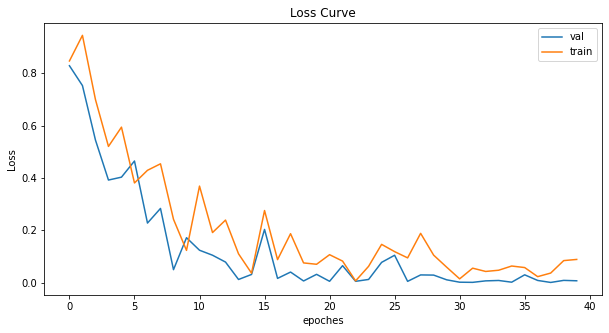

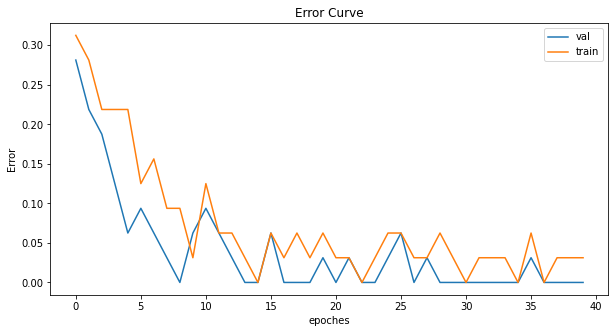

Forget time is: 312.10518431663513


In [ ]:
nm = hiding(cnn_model, loss='ce', optimizer='adam', epochs=40, device=device, dataset=forget, lossfn=None, train_loader=retain, val_loader=retain,
    scheduler=None, weight_decay=0.0, lr=0.01, momentum=0)

In [ ]:
test(model=nm, loss='ce', lossfn=None, optimizer='adam', device=device, dataset='cifar10', test_loader=retain, at_epoch=40, name="")

Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
[0] test metrics:{"loss": 0.007061602547764778, "error": 0.0}
FINISHED TESTING


In [ ]:
test(model=cnn_model, loss='ce', lossfn=None, optimizer='adam', device=device, dataset=forget, test_loader=retain, at_epoch=20)

Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
[0] test metrics:{"loss": 3.9441981315612793, "error": 1.0}
FINISHED TESTING


In [ ]:
random_labels(cnn_model, loss='ce', optimizer='adam', epochs=20, device=device, dataset=forget, lossfn=None, train_loader=retain,
   val_loader=forget, scheduler=None, weight_decay=0.1, lr=0.01, momentum=0.9)

Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
[Logging in CNN_training]
[0] train metrics:{"loss": 3.197683334350586, "error": 0.8125}
[0] test metrics:{"loss": 4.831615447998047, "error": 1.0}
Epoch number: 0 :
 Epoch Time: 5.47 sec
[1] train metrics:{"loss": 3.204857349395752, "error": 0.9375}
[1] test metrics:{"loss": 4.962646007537842, "error": 1.0}
Epoch number: 1 :
 Epoch Time: 5.43 sec
[2] train metrics:{"loss": 3.2000699043273926, "error": 0.9375}
[2] test metrics:{"loss": 4.994072914123535, "error": 1.0}
Epoch number: 2 :
 Epoch Time: 5.34 sec
[3] train metrics:{"loss": 3.1898672580718994, "error": 0.9375}
[3] test metrics:{"loss": 5.001162528991699, "error": 1.0}
Epoch number: 3 :
 Epoch Time: 5.44 sec
[4] train metrics:{"loss": 3.1801228523254395, "error": 0.9375}
[4] test metrics:{"loss": 4.999298095703125, "error": 1.0}
Epoch number: 4 :
 Epoch Time: 5.51 sec
[5] train metrics:{"loss": 3.1729676723480225, "error": 0.9375}
[5] test metrics:{"loss": 4.998154640197754

In [ ]:
test(model=cnn_model, loss='ce', lossfn=None, optimizer='adam', device=device, dataset='cifar10', test_loader=forget, at_epoch=20, name="random_lables")

Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
[0] test metrics:{"loss": 4.990996837615967, "error": 1.0}
FINISHED TESTING


In [ ]:
checkpoint = torch.load(f"/content/drive/My Drive/project/URP/checkpoints/{cnn_model.__class__.__name__}_{60}.pth.tar")
cnn_model.load_state_dict(checkpoint['model'])
test(model=cnn_model, loss='ce', lossfn=None, optimizer='adam', device=device, dataset='cifar', test_loader=retain, at_epoch=None)
neg_gradient(cnn_model, loss='ce', optimizer='adam', epochs=20, device=device, dataset="cifar", lossfn=None, train_loader=noisy_forget, val_loader=retain,
    scheduler=None, weight_decay=0.0, lr=0.01, momentum=0)

Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.09602899104356766
Error:  0.0
FINISHED TESTING
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
[Logging in CNN_training]
[0] train metrics:{"loss": 20.649782180786133, "error": 1.0}
[0] test metrics:{"loss": 59.956844329833984, "error": 1.0}
Epoch number: 0 :
 Epoch Time: 0.13 sec
[1] train metrics:{"loss": 8.156062126159668, "error": 1.0}
[1] test metrics:{"loss": 29.409408569335938, "error": 0.8947368413209915}
Epoch number: 1 :
 Epoch Time: 0.13 sec
[2] train metrics:{"loss": 3.9897754192352295, "error": 0.1904761791229248}
[2] test metrics:{"loss": 15.198840141296387, "error": 0.8947368413209915}
Epoch number: 2 :
 Epoch Time: 0.14 sec
[3] train metrics:{"loss": 2.1911768913269043, "error": 0.0476190447807312}
[3] test metrics:{"loss": 13.787266731262207, "error": 0.9473684206604958}
Epoch number: 3 :
 Epoch Time: 0.13 sec
[4] train metrics:{"loss": 1.0118478536605835, "error": 0.0}
[4] test metrics:{"loss

In [ ]:
test(model=cnn_model, loss='ce', lossfn=None, optimizer='adam', device=device, dataset='cifar', test_loader=retain, at_epoch=None)

Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  7.71566915512085
Error:  0.9473684206604958
FINISHED TESTING


CNN(
  (features): Sequential(
    (0): ConvUnit(
      (0): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): ConvUnit(
      (0): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): ConvUnit(
      (0): Conv2d(96, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Dropout(p=0.5, inplace=True)
    (4): ConvUnit(
      (0): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (5): ConvUnit(
      (0): Conv2